# Module 6 Final Project
* Student Name: PATRICK KIM
* Program: Data Science 
* Cohort: 06/24/19
* Due Date: 10/04/19
* Instructor: HOWARD SMITH

# Project Overview


## Context
Since it's inception in 2008, Airbnb has disrupted the traditional hospitality industry as more and more travelers are opting to choose Airbnb as their primary accommodation provider. Initially starting off with two bookings, Airbnb has now grown to host over six million listings worldwide across over 100 thousand cities.

In the United States of America, Airbnb has reached markets across the nation. In California, no city is more popular than Los Angeles. With over 44,500 listings as of July 2019, Los Angeles is the second largest host city behind New York City. With a size of 503 $mi^{2}$, this means there are roughly 88 listings being rented our per $mi^{2}$ in Los Angeles on Airbnb!

## Content
The dataset consists of multiple files that house various points of data. We will be using the files listed in bold. Below are the file descriptions:
* **listings.csv** - detailed listings data for each rental (name, bedrooms, bath, sq ft, location, etc.)
* reviews.csv - detailed review data for each rental (listing ID, review date, comments, etc.)
* calendar.csv - detailed calendar data for each rental (booking status, date of booking, etc.)
* neighbourhoods.csv - summary list of every neighborhood in Los Angeles
* neighbourhoods.geojson - GeoJSON file of neighbourhoods of the city

## Acknowledgment
The data is available at: http://insideairbnb.com

Inside Airbnb is an independent, non-commercial set of tools and data that allows you to explore how Airbnb is really being used in cities around the world. 

## Goal
The goal of this notebook is to use linear regression models to analyze data trends to **help Airbnb host better understand the hospitality market and to use this gained knowledge to make informed decisions regarding their listing(s).** The following questions will drive this project:
* **Can we predict daily prices for a listing that fits into its specific market environment and competitors in Los Angeles?**


## Approach
The **OSEMiN Process** is an acronym that stands for **Obtain, Scrub, Explore, Model, and iNterpret**. It is used as a blueprint for working on data problems using machine learning tools. Preprocessing involves scrubbing (also called cleaning) and exploring the data. Building the model, evaluating, and optimizing it make up the process of machine learning.

# Table of Contents
<a id='Table of contents'></a>

<a href='#1. Obtaining and Viewing the Data'> 1. Obtaining and Viewing the Data </a>

<a href='#2. Preprocessing the Data'> 2. Preprocessing the Data </a>
* <a href='#2.1. Deciding which columns to work with'> 2.1. Deciding which columns to work with </a>
* <a href='#2.2. Cleaning Price Columns'> 2.2. Cleaning Price Columns </a>
* <a href='#2.3. Dealing with Missing Values'> 2.3. Dealing with Missing Values </a>
* <a href='#2.4. Feature Engineering 1: Distance to Centroid of Berlin'> 2.4. Feature Engineering 1: Distance to Centroid of Berlin </a>
* <a href='#2.5. Feature Engineering 2: Lodging Size'> 2.5. Feature Engineering 2: Lodging Size </a>
* <a href='#2.6. Feature Engineering 3: Lodging Amenities'> 2.6. Feature Engineering 3: Lodging Amenities </a>

<a href='#3. Exploratory Data Analysis (EDA)'> 3. Exploratory Data Analysis (EDA) </a>

<a href='#4. Modeling the Data'> 4. Modeling the Data </a>
* <a href='#4.1. Preparing Target and Features'> 4.1. Preparing Target and Features </a>
* <a href='#4.2. Splitting and Scaling the Data'> 4.2. Splitting and Scaling the Data </a>
* <a href='#4.3. Training an XGBoost Regressor'> 4.3. Training an XGBoost Regressor </a>
* <a href='#4.4. Cross Validation'> 4.4. Cross Validation </a>

<a href='#5. Interpreting the Data'> 5. Interpreting the Data </a>

<a href='#6. Appendix'> 6. Appendix </a>

### 1. Obtaining and Viewing the Data 
<a id='1. Obtaining and Viewing the Data'></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import re
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_initial = pd.read_csv('../ds-6-project/LA/listings.csv')

# checking shape
print("The dataset has {} rows and {} columns.".format(*df_initial.shape))

# ... and duplicates
print("It contains {} duplicates.".format(df_initial.duplicated().sum()))

The dataset has 44620 rows and 106 columns.
It contains 0 duplicates.


In [3]:
df_initial.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,109,https://www.airbnb.com/rooms/109,20190708161040,2019-07-09,Amazing bright elegant condo park front *UPGRA...,"*** Unit upgraded with new bamboo flooring, br...","*** Unit upgraded with new bamboo flooring, br...","*** Unit upgraded with new bamboo flooring, br...",none,NaN,...,f,f,strict_14_with_grace_period,t,f,1,1,0,0,0.02


In [4]:
# check the columns we currently have
df_initial.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object', length=106)

*Back to: <a href='#Table of contents'> Table of contents</a>*
### 2. Preprocessing the Data 
<a id='2. Preprocessing the Data'></a>

#### 2.1. Deciding which columns to work with 
<a id='2.1. Deciding which columns to work with'></a>

Let's imagine we are in the shoes of someone who'd like to offer their home. Fixed features of our property include its rooms, size, and location. We also can decide on how we want to be listed: with a picture or not, how many minimum nights we want a guest to stay, whether we are instantly bookable, how we handle cancellations, etc. But we can neither be a "super host", nor do we have any reviews yet to show - although they can be very important for setting a price. So, let's focus only on features we can influence:

In [5]:
# define the columns we want to keep
columns_to_keep = ['id', 'space', 'description', 'host_is_superhost', 'host_has_profile_pic',
                   'host_identity_verified', 'neighbourhood_cleansed', 
                   'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms', 'beds', 'first_review', 'last_review', 'bed_type', 'amenities', 'square_feet', 
                  'price', 'cleaning_fee', 
                   'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',  
                   'instant_bookable', 'is_business_travel_ready', 'cancellation_policy']

df_raw = df_initial[columns_to_keep].set_index('id')
print("The dataset has {} rows and {} columns - after dropping irrelevant columns.".format(*df_raw.shape))

The dataset has 44620 rows and 28 columns - after dropping irrelevant columns.


By the way, how many different **room types** do we have?

In [6]:
df_raw.room_type.value_counts(normalize=True)

Entire home/apt    0.631376
Private room       0.327073
Shared room        0.041551
Name: room_type, dtype: float64

And how many different **property types** are we up against?

In [7]:
df_raw.property_type.value_counts(normalize=True)

Apartment                 0.371201
House                     0.338144
Condominium               0.057060
Guesthouse                0.052532
Guest suite               0.033236
Townhouse                 0.030973
Bungalow                  0.028238
Villa                     0.022524
Loft                      0.022277
Serviced apartment        0.007060
Hostel                    0.006365
Bed and breakfast         0.005289
Cottage                   0.004393
Camper/RV                 0.003855
Other                     0.003160
Boutique hotel            0.002913
Tiny house                0.001927
Cabin                     0.001793
Hotel                     0.001098
Boat                      0.000896
Aparthotel                0.000784
Farm stay                 0.000628
Tent                      0.000560
Castle                    0.000426
Earth house               0.000403
Chalet                    0.000314
Treehouse                 0.000269
Campsite                  0.000224
Dome house          

*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 2.2. Cleaning Price Columns
<a id='2.2. Cleaning Price Columns'></a>

In [8]:
df_raw[['price', 'cleaning_fee', 'extra_people', 'security_deposit']].head(3)

,price,cleaning_fee,extra_people,security_deposit
id,,,,
109,$122.00,$240.00,$25.00,$500.00
344,$168.00,$100.00,$0.00,$0.00
2708,$79.00,$89.00,$0.00,$480.00


Let's first check if there are any null values in the `price` column:

In [9]:
# checking Nan's in "price" column
df_raw.price.isna().sum()

0

No, so we don't need to drop any rows. And what about the `cleaning_fee`?

In [10]:
# Nan's in "cleaning_fee" column
df_raw.cleaning_fee.isna().sum()

5927

There are plenty of Nan's. It's more than likely that these hosts do not charge any extra cleaning fee. So let's simply replace these null values with $0.00:

In [11]:
df_raw.cleaning_fee.fillna('$0.00', inplace=True)
df_raw.cleaning_fee.isna().sum()

0

The same is true for the `security_deposit`:

In [12]:
df_raw.security_deposit.isna().sum()

10792

In [13]:
df_raw.security_deposit.fillna('$0.00', inplace=True)
df_raw.security_deposit.isna().sum()

0

In [14]:
df_raw.extra_people.isna().sum()

0

Let's remove the dollar signs in all four columns and convert the string values into numerical ones:

In [15]:
# clean up the columns (by method chaining)
df_raw.price = df_raw.price.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.cleaning_fee = df_raw.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.security_deposit = df_raw.security_deposit.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.extra_people = df_raw.extra_people.str.replace('$', '').str.replace(',', '').astype(float)

We shouldn't miss investigating the `price` - it might need some cleaning to be of use to us:

In [16]:
df_raw['price'].describe()

count    44620.000000
mean       211.848364
std        578.938791
min          0.000000
25%         70.000000
50%        110.000000
75%        186.000000
max      25000.000000
Name: price, dtype: float64

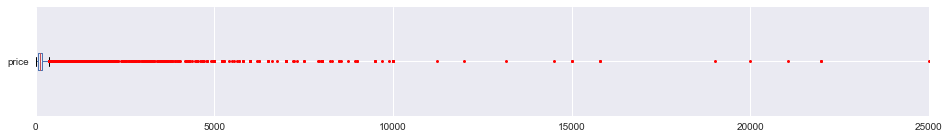

In [17]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df_raw['price'].plot(kind='box', xlim=(0, 25000), vert=False, flierprops=red_square, figsize=(16,2));

A bit messy, as expected! 

75% of the apartments charge up to 68€ - but the maximum value is 9000€. Let's decide on a limit of 400€, after which the outliers seem to "fringe", and drop all records that charge more than that. Oddly enough, we have prices set to zero. So let's drop those records, too:

In [18]:
df_raw.drop(df_raw[ (df_raw.price > 7500) | (df_raw.price == 0) ].index, axis=0, inplace=True)

In [19]:
df_raw['price'].describe()

count    44549.000000
mean       196.670924
std        384.635964
min         10.000000
25%         70.000000
50%        110.000000
75%        185.000000
max       7500.000000
Name: price, dtype: float64

In [20]:
print("The dataset has {} rows and {} columns - after being price-wise preprocessed.".format(*df_raw.shape))

The dataset has 44549 rows and 28 columns - after being price-wise preprocessed.


*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 2.3. Dealing with Missing Values
<a id='2.3. Dealing with Missing Values'></a>

In [21]:
df_raw.isna().sum()

space                       11276
description                  1028
host_is_superhost              14
host_has_profile_pic           14
host_identity_verified         14
neighbourhood_cleansed          0
latitude                        0
longitude                       0
property_type                   0
room_type                       0
accommodates                    0
bathrooms                      22
bedrooms                       17
beds                           61
first_review                 8609
last_review                  8609
bed_type                        0
amenities                       0
square_feet                 44194
price                           0
cleaning_fee                    0
security_deposit                0
extra_people                    0
guests_included                 0
minimum_nights                  0
instant_bookable                0
is_business_travel_ready        0
cancellation_policy             0
dtype: int64

In [22]:
# drop columns with too many Nan's
df_raw.drop(columns=['square_feet', 'space'], inplace=True)

**bathrooms, bedrooms and beds**

There are 22, 18, 63 missing values for bathrooms, bedrooms, and beds respectively. We will fill these NaN values with the median values for each feature.

In [23]:
for col in ['bathrooms', 'bedrooms', 'beds']:
    df_raw[col].fillna(df_raw[col].median(), inplace=True)

In [24]:
print(df_raw.host_has_profile_pic.unique())
print(df_raw.host_is_superhost.unique())
print(df_raw.host_identity_verified.unique())

['t' 'f' nan]
['f' 't' nan]
['t' 'f' nan]


In [25]:
# replace host_has_profile_pic Nan's with no
df_raw.host_has_profile_pic.fillna(value='f', inplace=True)
df_raw.host_is_superhost.fillna(value='f', inplace=True)
df_raw.host_identity_verified.fillna(value='f', inplace=True)

print(df_raw.host_has_profile_pic.unique())
print(df_raw.host_is_superhost.unique())
print(df_raw.host_identity_verified.unique())

['t' 'f']
['f' 't']
['t' 'f']


In [26]:
df_raw.isna().sum()

description                 1028
host_is_superhost              0
host_has_profile_pic           0
host_identity_verified         0
neighbourhood_cleansed         0
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                      0
bedrooms                       0
beds                           0
first_review                8609
last_review                 8609
bed_type                       0
amenities                      0
price                          0
cleaning_fee                   0
security_deposit               0
extra_people                   0
guests_included                0
minimum_nights                 0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
dtype: int64

In [27]:
print("The dataset has {} rows and {} columns - after having dealt with missing values.".format(*df_raw.shape))

The dataset has 44549 rows and 26 columns - after having dealt with missing values.


**property_type**

There are various property types in this column that have few listings. Therefore, we may have to clean this feature to broader categories. We will use "house", "apartment", and "other" to capture all listing types.

In [28]:
df_raw.property_type.value_counts(normalize=True)

Apartment                 0.371636
House                     0.338122
Condominium               0.057128
Guesthouse                0.052616
Guest suite               0.033244
Townhouse                 0.031022
Bungalow                  0.028261
Loft                      0.022313
Villa                     0.021774
Serviced apartment        0.007071
Hostel                    0.006375
Bed and breakfast         0.005298
Cottage                   0.004400
Camper/RV                 0.003861
Other                     0.003165
Boutique hotel            0.002918
Tiny house                0.001930
Cabin                     0.001796
Hotel                     0.001100
Boat                      0.000898
Aparthotel                0.000786
Farm stay                 0.000629
Tent                      0.000561
Castle                    0.000426
Earth house               0.000404
Chalet                    0.000314
Treehouse                 0.000269
Campsite                  0.000224
Dome house          

In [29]:
# replacing categories that are types of houses or apartments
df_raw.property_type.replace({
    'Condominium': 'Apartment',
    'Guesthouse': 'House',
    'Townhouse': 'House',
    'Bungalow': 'House',
    'Villa': 'House',
    'Cottage': 'House',
    'Serviced apartment': 'Apartment',
    'Tiny house': 'House',
    'Cabin': 'House',
    'Earth house': 'House',
    'Castle': 'House',
    'Dome house': 'House'
    }, inplace=True)

# replacing other categories with 'other'
df_raw.loc[~df_raw.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

**bed_type**

After taking a look at the distribution of results, there is a hard skew towards the "Real Bed" value and this may introduce bias and is imbalanced. We will drop this column.

In [30]:
df_raw.bed_type.value_counts(normalize=True)

Real Bed         0.988844
Futon            0.004355
Pull-out Sofa    0.002761
Airbed           0.002402
Couch            0.001639
Name: bed_type, dtype: float64

In [31]:
df_raw.drop('bed_type', axis=1, inplace=True)

**first_review, last_review**

About a fifth of listings have not had a review written for them. This is too large a proportion of the dataset to drop, and dropping the columns would lose a lot of useful information - reviews are very important in people's decisions to book, and therefore price.

This is also too large a proportion of the dataset to simply replace with median/mean values, as this would skew the distribution substantially. Also, the missing values here are not really missing values, as the fact that they are NaNs is meaningful - it tells us that these are new or previously unbooked listings that have not had reviews yet. In order to make the resulting model work able to predict prices for any Airbnb listing, including brand new listings, is is actually beneficial to keep them in. Therefore, these will be kept as an 'unknown' category, and the feature will have to be treated as categorical (and therefore one-hot encoded) rather than numerical.

In [33]:
print(f"Null values in 'first_review': {round(100*df_raw.first_review.isna().sum()/len(df_raw),1)}%")

Null values in 'first_review': 19.3%


In [34]:
# import library
from datetime import datetime

# converting to datetime
df_raw.first_review = pd.to_datetime(df_raw.first_review)

# calculating the number of days between the first review and the date the data was scraped
df_raw['time_since_first_review'] = (datetime(2019, 4, 9) - df_raw.first_review).astype('timedelta64[D]')

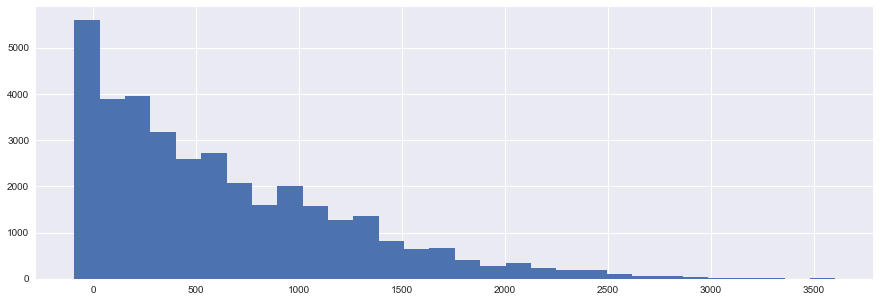

In [35]:
# distribution of the number of days since first review
df_raw.time_since_first_review.hist(figsize=(15,5), bins=30);

In [36]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df_raw[col] = pd.cut(df_raw[col], bins=bins, labels=labels, include_lowest=True)
    df_raw[col] = df_raw[col].astype('str')
    df_raw[col].fillna(na_label, inplace=True)

In [37]:
# binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(df_raw.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

In [38]:
# converting to datetime
df_raw.last_review = pd.to_datetime(df_raw.last_review)

# calculating the number of days between the most recent review and the date the data was scraped
df_raw['time_since_last_review'] = (datetime(2019, 4, 9) - df_raw.last_review).astype('timedelta64[D]')

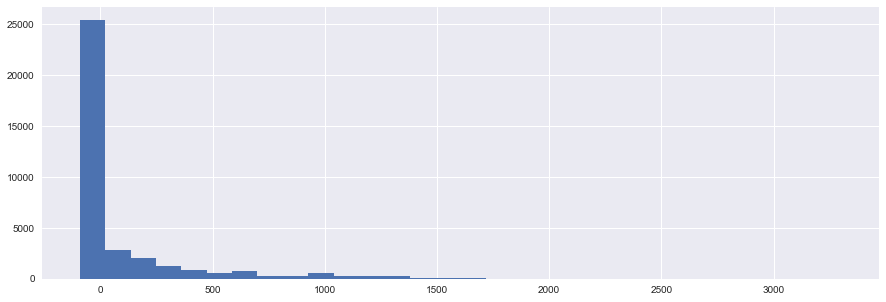

In [39]:
# distribution of the number of days since last review
df_raw.time_since_last_review.hist(figsize=(15,5), bins=30);

In [40]:
# binning time since last review
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(df_raw.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

In [41]:
# dropping last_review - first_review will be kept for EDA and dropped later
df_raw.drop('last_review', axis=1, inplace=True)

**cancellation_policy**

Some cleaning of cancellation policy types is required, in order to categorise the four very small categories into the three larger categories (e.g. the super strict options are only available to long-term Airbnb hosts, and is invitation only).

In [42]:
df_raw.cancellation_policy.value_counts()

strict_14_with_grace_period    19046
flexible                       12926
moderate                       12087
super_strict_60                  207
strict                           190
luxury_moderate                   76
luxury_super_strict_95             8
super_strict_30                    7
luxury_no_refund                   2
Name: cancellation_policy, dtype: int64

In [43]:
# replacing categories
df_raw.cancellation_policy.replace({
    'super_strict_30': 'strict_14_with_grace_period',
    'super_strict_60': 'strict_14_with_grace_period',
    'strict': 'strict_14_with_grace_period',
    'luxury_super_strict_95': 'strict_14_with_grace_period',
    'luxury_no_refund': 'strict_14_with_grace_period',
    'luxury_moderate': 'moderate'
    }, inplace=True)

*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 2.4. Feature Engineering 1: Distance to Centroid of Los Angeles
<a id='2.4. Feature Engineering 1: Distance to Centroid of Berlin'></a>

Location is always an important factor in lodging services. To make it more descriptive, I decided to calculate each accommodation's distance to the so-called centroid of Berlin instead of just relying on the neighbourhoods or areas. 

For our convenience, let's write a quick function that does this, apply it to each accommodation, and store the values in a new column:

In [44]:
from geopy.distance import great_circle

In [45]:
def distance_to_mid(lat, lon):
    downtown_la = (34.0407, -118.2468)
    accommodation = (lat, lon)
    return great_circle(downtown_la, accommodation).miles

In [46]:
df_raw['distance'] = df_raw.apply(lambda x: distance_to_mid(x.latitude, x.longitude), axis=1)

In [47]:
df_raw.head(2)

,description,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,...,security_deposit,extra_people,guests_included,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,time_since_first_review,time_since_last_review,distance
id,,,,,,,,,,,,,,,,,,,,,
109,"*** Unit upgraded with new bamboo flooring, br...",f,t,t,Culver City,33.98209,-118.38494,Apartment,Entire home/apt,6,...,500.0,25.0,3,30,f,f,strict_14_with_grace_period,4+ years,1+ year,8.887891
344,This home is perfect for families; aspiring ch...,f,t,t,Burbank,34.16562,-118.33458,House,Entire home/apt,6,...,0.0,0.0,6,2,t,f,flexible,2-3 years,2-6 months,9.985858


*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 2.6. Feature Engineering 3: Lodging Amenities
<a id='2.6. Feature Engineering 3: Lodging Amenities'></a>

I'm interested in what amenities hosts offer their guests, and in order to enrich our prediction, whether we can determine what some of the more special and/or rare amenities might be that make a property more desirable.

In [48]:
# creating a list of all possible amenities
amenities_list = list(df_raw.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set

{'',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air purifier',
 'Alarm system',
 'Alfresco bathtub',
 'Alfresco shower',
 'Amazon Echo',
 'Apple TV',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Balcony',
 'Bar',
 'Basketball court',
 'Bath towel',
 'Bathroom essentials',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach chairs',
 'Beach essentials',
 'Beach view',
 'Beachfront',
 'Bed linens',
 'Bedroom comforts',
 'Bicycle',
 'Bidet',
 'Blu-Ray player',
 'Boat',
 'Body soap',
 'Breakfast',
 'Breakfast bar',
 'Breakfast table',
 'Brick oven',
 'Building staff',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Ceiling fan',
 'Ceiling fans',
 'Ceiling hoist',
 'Central air conditioning',
 'Changing table',
 'Chapel',
 'Charcoal barbeque',
 "Chef's kitchen",
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Compute

In [49]:
# creating new columns of amenities
df_raw.loc[df_raw['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
df_raw.loc[df_raw['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df_raw.loc[df_raw['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
df_raw.loc[df_raw['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df_raw.loc[df_raw['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df_raw.loc[df_raw['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df_raw.loc[df_raw['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df_raw.loc[df_raw['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df_raw.loc[df_raw['amenities'].str.contains('TV'), 'tv'] = 1
df_raw.loc[df_raw['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df_raw.loc[df_raw['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df_raw.loc[df_raw['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df_raw.loc[df_raw['amenities'].str.contains('Elevator'), 'elevator'] = 1
df_raw.loc[df_raw['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df_raw.loc[df_raw['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df_raw.loc[df_raw['amenities'].str.contains('parking'), 'parking'] = 1
df_raw.loc[df_raw['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df_raw.loc[df_raw['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df_raw.loc[df_raw['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df_raw.loc[df_raw['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df_raw.loc[df_raw['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df_raw.loc[df_raw['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
df_raw.loc[df_raw['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df_raw.loc[df_raw['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df_raw.loc[df_raw['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
df_raw.loc[df_raw['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
df_raw.loc[df_raw['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
df_raw.loc[df_raw['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

In [50]:
# replacing nulls with zeros for new columns
cols_to_replace_nulls = df_raw.iloc[:,28:].columns
df_raw[cols_to_replace_nulls] = df_raw[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in df_raw.iloc[:,28:].columns:
    if df_raw[col].sum() < len(df_raw)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
df_raw.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
df_raw.drop('amenities', axis=1, inplace=True)

['high_end_electronics', 'nature_and_views', 'smoking_allowed', 'accessible', 'event_suitable']


In [51]:
df_raw.columns[27:]

Index(['air_conditioning', 'bbq', 'balcony', 'bed_linen', 'breakfast', 'tv',
       'coffee_machine', 'cooking_basics', 'white_goods', 'elevator', 'gym',
       'child_friendly', 'parking', 'outdoor_space', 'host_greeting',
       'hot_tub_sauna_or_pool', 'internet', 'long_term_stays', 'pets_allowed',
       'private_entrance', 'secure', 'self_check_in'],
      dtype='object')

Let's add columns with amenities that are somewhat unique and not offered by all hosts: 
- a laptop-friendly workspace
- a TV
- kid friendly accommodation 
- smoker friendly and 
- being greeted by the host.

After doing this, let's drop the original column:

*Back to: <a href='#Table of contents'> Table of contents</a>*
### 3. Exploratory Data Analysis (EDA)
<a id='3. Exploratory Data Analysis (EDA)' ></a>

**> Price Differences on a Map**

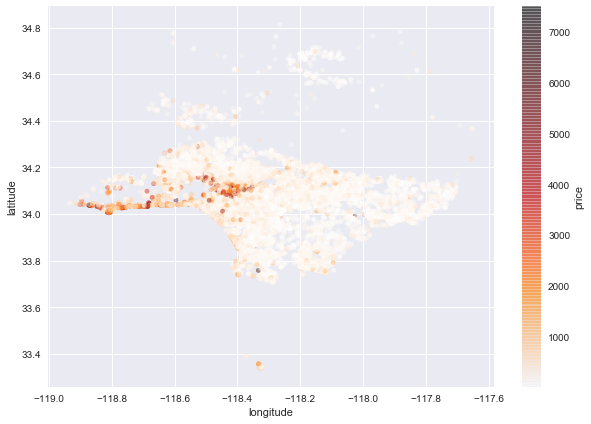

In [52]:
df_raw.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), 
        c="price", cmap="gist_heat_r", colorbar=True, sharex=False);

**> Price Differences by Neighbourhood**

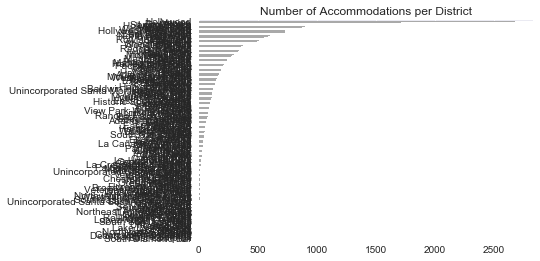

In [53]:
df_raw['neighbourhood_cleansed'].value_counts().sort_values().plot(kind='barh', color='darkgrey')
plt.title('Number of Accommodations per District');

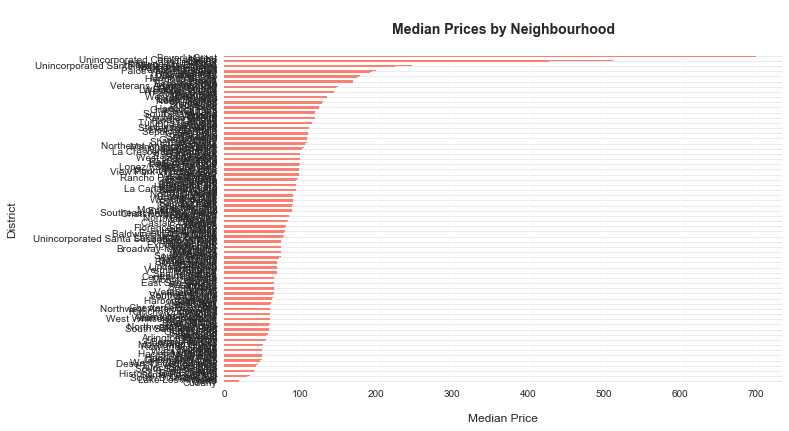

In [54]:
# group_by neighbourhood groups, take the median price and store new values in sub_df 
df_grouped = pd.DataFrame(df_raw.groupby(['neighbourhood_cleansed'])['price'].agg(np.median))
df_grouped.reset_index(inplace=True)

# plot this 
df_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='neighbourhood_cleansed', y='price', 
                figsize=(10,6), legend=False, color='salmon')

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nMedian Prices by Neighbourhood\n', fontsize=14, fontweight='bold');

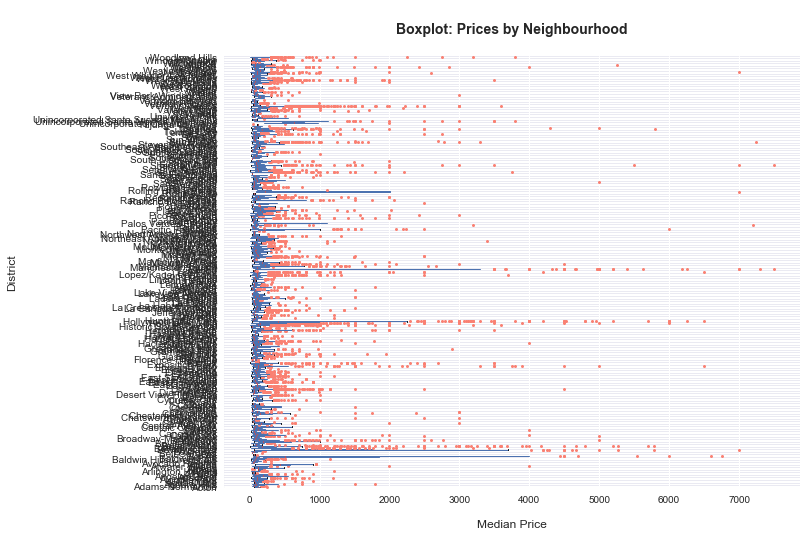

In [55]:
red_square = dict(markerfacecolor='salmon', markeredgecolor='salmon', marker='.')

df_raw.boxplot(column='price', by='neighbourhood_cleansed', 
           flierprops=red_square, vert=False, figsize=(10,8))

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nBoxplot: Prices by Neighbourhood\n', fontsize=14, fontweight='bold')

# get rid of automatic boxplot title
plt.suptitle('');

**> Price Differences by Accommodation Distance to Center of Berlin**

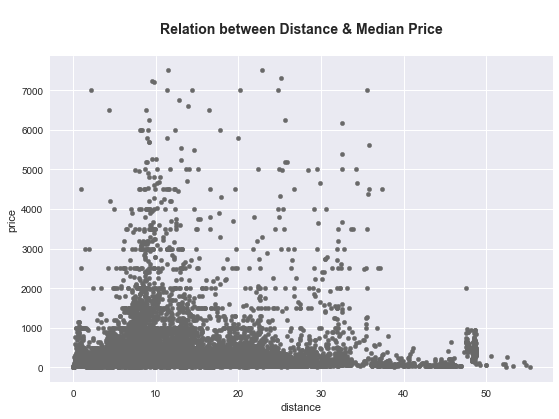

In [56]:
df_raw.plot.scatter(x="distance", y="price", figsize=(9,6), c='dimgrey')
plt.title('\nRelation between Distance & Median Price\n', fontsize=14, fontweight='bold');

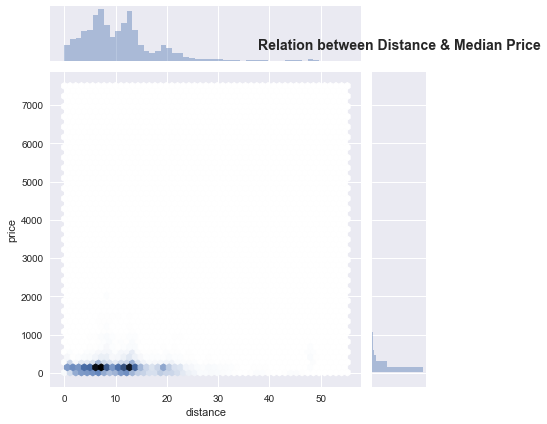

In [57]:
sns.jointplot(x=df_raw["distance"], y=df_raw["price"], kind='hex')
plt.title('\nRelation between Distance & Median Price\n', fontsize=14, fontweight='bold');

**> Price Differences by Number of Bedrooms**

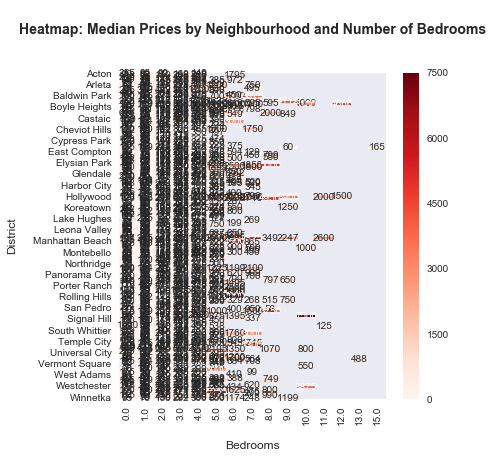

In [58]:
plt.figure(figsize=(6,6))
sns.heatmap(df_raw.groupby(['neighbourhood_cleansed', 'bedrooms']).price.median().unstack(), 
            cmap='Reds', annot=True, fmt=".0f")

plt.xlabel('\nBedrooms', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nHeatmap: Median Prices by Neighbourhood and Number of Bedrooms\n\n', fontsize=14, fontweight='bold');

Text(0.5, 1.0, 'Number of Room Types')

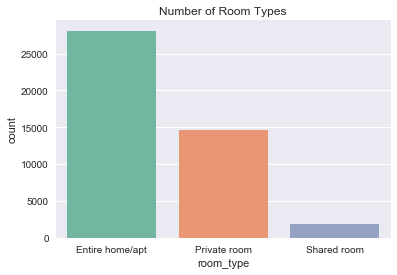

In [89]:
sns.countplot(x="room_type", data=df_raw, palette="Set2").set_title('Number of Room Types')

Text(0.5, 1.0, 'Number of Bathrooms')

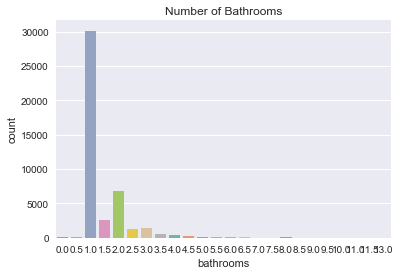

In [92]:
sns.countplot(x="bathrooms", data=df_raw, palette="Set2").set_title('Number of Bathrooms')

Text(0.5, 1.0, 'Number of Bedrooms')

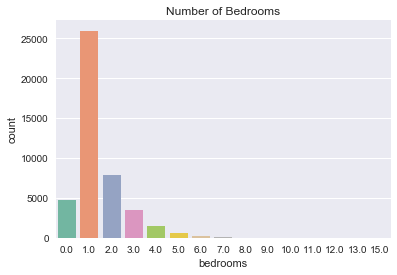

In [93]:
sns.countplot(x="bedrooms", data=df_raw, palette="Set2").set_title('Number of Bedrooms')

Text(0.5, 1.0, 'Number of Property Types')

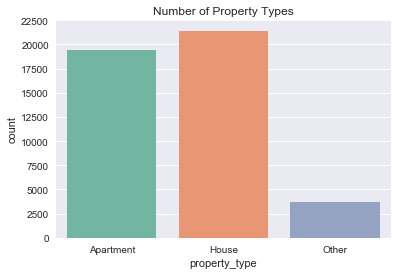

In [98]:
sns.countplot(x="property_type", data=df_raw, palette="Set2").set_title('Number of Property Types')

**> Price Differences by Cancellation Policy**

*Back to: <a href='#Table of contents'> Table of contents</a>*
### 4. Modeling the Data 
<a id='4. Modeling the Data'></a>

#### 4.1. Preparing Target and Features
<a id='4.1. Preparing Target and Features'></a>

In [60]:
df_raw.columns

Index(['description', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'first_review', 'price', 'cleaning_fee',
       'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'time_since_first_review', 'time_since_last_review', 'distance',
       'check_in_24h', 'air_conditioning', 'bbq', 'balcony', 'bed_linen',
       'breakfast', 'tv', 'coffee_machine', 'cooking_basics', 'white_goods',
       'elevator', 'gym', 'child_friendly', 'parking', 'outdoor_space',
       'host_greeting', 'hot_tub_sauna_or_pool', 'internet', 'long_term_stays',
       'pets_allowed', 'private_entrance', 'secure', 'self_check_in'],
      dtype='object')

In [64]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44549 entries, 109 to 36498289
Data columns (total 40 columns):
host_is_superhost           44549 non-null category
host_has_profile_pic        44549 non-null category
property_type               44549 non-null category
room_type                   44549 non-null object
accommodates                44549 non-null int64
bathrooms                   44549 non-null float64
bedrooms                    44549 non-null float64
price                       44549 non-null float64
cleaning_fee                44549 non-null float64
security_deposit            44549 non-null float64
extra_people                44549 non-null float64
guests_included             44549 non-null int64
minimum_nights              44549 non-null int64
instant_bookable            44549 non-null object
is_business_travel_ready    44549 non-null object
cancellation_policy         44549 non-null object
distance                    44549 non-null float64
check_in_24h              

As we work with the distance to the center, let's drop the `neighbourhood_group_cleansed`. Furthermore, `property_types` may not be that helpful.

In [68]:
df_raw.drop(['latitude', 'longitude', 'neighbourhood_cleansed', 'beds', 'host_identity_verified', 'description', 'first_review', 'time_since_first_review', 'time_since_last_review'], axis=1, inplace=True)

KeyError: "['latitude' 'longitude' 'neighbourhood_cleansed' 'beds' 'description'\n 'first_review' 'time_since_first_review' 'time_since_last_review'] not found in axis"

Now let's convert all string columns into categorical ones:

In [69]:
for col in ['host_has_profile_pic', 'host_is_superhost', 'property_type','room_type', 
            'instant_bookable', 
            'is_business_travel_ready', 'cancellation_policy']:
    df_raw[col] = df_raw[col].astype('category')

In [70]:
# define our target
target = df_raw[["price"]]

# define our features 
features = df_raw.drop(["price"], axis=1)

***Recoding Categorical Features***

Machine learning algorithms generally need all data - including categorical data - in numeric form. To satisfy these algorithms, categorical features are converted into separate binary features called dummy variables. Therefore, we have to find a way to represent these variables as numbers before handing them off to the model. One typical way of doing this in one-hot encoding, which creates a new column for each unique category in a categorical variable. Each observation receives a 1 in the column for its corresponding category (= "HOT") and a 0 in all other new columns. To conduct one-hot encoding, we use the pandas get_dummies function.

In [71]:
num_feats = features.select_dtypes(include=['float64', 'int64', 'bool']).copy()

# one-hot encoding of categorical features
cat_feats = features.select_dtypes(include=['category']).copy()
cat_feats = pd.get_dummies(cat_feats)

In [72]:
features_recoded = pd.concat([num_feats, cat_feats], axis=1)

In [73]:
print(features_recoded.shape)
features_recoded.head(2)

(44549, 48)


,accommodates,bathrooms,bedrooms,cleaning_fee,security_deposit,extra_people,guests_included,minimum_nights,distance,check_in_24h,...,property_type_Other,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,instant_bookable_f,instant_bookable_t,is_business_travel_ready_f,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period
id,,,,,,,,,,,,,,,,,,,,,
109,6,2.0,2.0,240.0,500.0,25.0,3,30,8.887891,1.0,...,0,1,0,0,1,0,1,0,0,1
344,6,1.0,3.0,100.0,0.0,0.0,6,2,9.985858,1.0,...,0,1,0,0,0,1,1,1,0,0


#### 4.2. Splitting and Scaling the Data
<a id='4.2. Splitting and Scaling the Data'></a>

In [74]:
# import train_test_split function
from sklearn.model_selection import train_test_split
# import metrics
from sklearn.metrics import mean_squared_error, r2_score

# split our data
X_train, X_test, y_train, y_test = train_test_split(features_recoded, target, test_size=0.2)

One of the challenges in building models is mixing features that have different scales. Look at our dataset and compare bathrooms with size or maximum_nights. When we mix units with ranges that have different orders of magnitude, our models may not be able to find the proper coefficients. To account for this problem, we standardize or normalize the features.

In [75]:
# scale data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

#### 4.3. Training an XGBoost Regressor
<a id='4.3. Training an XGBoost Regressor'></a>

In [76]:
# create a baseline
booster = xgb.XGBRegressor()

Some of the important hyperparameters to tune an XGBoost are:
- `n_estimators` $\;\;\;\;\;$ = Number of trees one wants to build.
- `learning_rate` $\;\;\;\;$= Rate at which our model learns patterns in data. After every round, it shrinks the feature weights to reach the best optimum.
- `max_depth` $\;\;\;\;\;\;\;\;\;\;\;$= Determines how deeply each tree is allowed to grow during any boosting round.
- `colsample_bytree` = Percentage of features used per tree. 
- `gamma` $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$= Specifies the minimum loss reduction required to make a split.

In [ ]:
from sklearn.model_selection import GridSearchCV

# create Grid
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(X_train, y_train)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

In [77]:
# instantiate xgboost with best parameters
booster = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.0, learning_rate=0.1, 
                           max_depth=6, n_estimators=200, random_state=4)

# train
booster.fit(X_train, y_train)

# predict
y_pred_train = booster.predict(X_train)
y_pred_test = booster.predict(X_test)

[13:58:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [78]:
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(RMSE, 4)}")

RMSE: 218.7405


In [79]:
r2 = r2_score(y_test, y_pred_test)
r2
print(f"r2: {round(r2, 4)}")

r2: 0.6704


#### 4.4. Cross Validation
<a id='4.4. Cross Validation'></a>

In order to build more robust models, it is common to conduct a k-fold cross validation where all the entries in the original training dataset are used for both training and validation. XGBoost supports k-fold cross validation via the cv method. All we have to do is specify the `nfolds` parameter, which is the number of cross validation rounds you want to build. 

Also, it supports many other parameters:
- `num_boost_round` $\;\;\;\;\;\;\;\;$ = Specifies the number of trees to build (analogous to n_estimators).
- `metrics` $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ = Specifies the evaluation metrics to be checked during CV.
- `as_pandas` $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$= Returns the results in a decent pandas DataFrame.
- `early_stopping_rounds` = Finishes model training early if the hold-out metric does not improve for a given number of rounds. 

We will have to first convert the dataset into an optimized data structure called DMatrix so that XGBoost's cross validation method is supported.

In [80]:
xg_train = xgb.DMatrix(data=X_train, label=y_train)

In [81]:
params = {'colsample_bytree':0.7, 'gamma':0.0, 'learning_rate':0.1, 'max_depth':6}

cv_results = xgb.cv(dtrain=xg_train, params=params, nfold=3,
                    num_boost_round=200, early_stopping_rounds=10, 
                    metrics="rmse", as_pandas=True)

In [82]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,402.270996,7.300668,404.041015,15.362013
1,375.381053,7.395250,379.233907,16.112943
2,351.852773,7.711554,357.033030,16.171304
3,330.383209,7.332320,337.861125,16.336853
4,311.610545,7.437015,320.989014,17.135836


In [83]:
cv_results.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
91,130.502363,5.236901,211.635203,12.649659
92,130.243606,5.126645,211.621653,12.667901
93,129.980110,5.139584,211.569916,12.646407
94,129.677277,5.142070,211.526199,12.673085
95,129.429204,5.290920,211.509893,12.628114


*Back to: <a href='#Table of contents'> Table of contents</a>*
### 5. Interpreting the Data 
<a id='5. Interpreting the Data'></a>

In [87]:
df_raw.price.describe()

count    44549.000000
mean       196.670924
std        384.635964
min         10.000000
25%         70.000000
50%        110.000000
75%        185.000000
max       7500.000000
Name: price, dtype: float64

We can see that our average error (RMSE) in the initial XGBoost is around 218$, which improves to 129$ by cross validation. Given the fact that after cleaning up the price column, 50% of our lodgings cost only up to 110$ and 75 percent of our lodgings up to 185$ - even the improved standard deviation of 129$ is quite a massive inaccuracy that doesn't help much in recommending a price.

It turns out that the price is dependent not only on geography, size, and features. It stands to reason that 
- the quality of presentation (e.g. pictures), 
- availability, 
- the number and content of reviews, 
- communication (e.g. acceptance rate, host response time) 

might have a substantial influence too. But the purpose of this analysis was to recommend a price to a "rookie" without any reviews or status. With this in mind, we might say that we can't recommend an exact price, but rather a range..

The next step (and maybe an idea for the reader) would be to start all over again and include the features mentioned above to try to find out if accuracy improves. That might help a beginner on Airbnb better know what price to aim for.

With what we have done here, we have explained 71% of the variance (R^2) with the most important accommodation features, as pictured below:

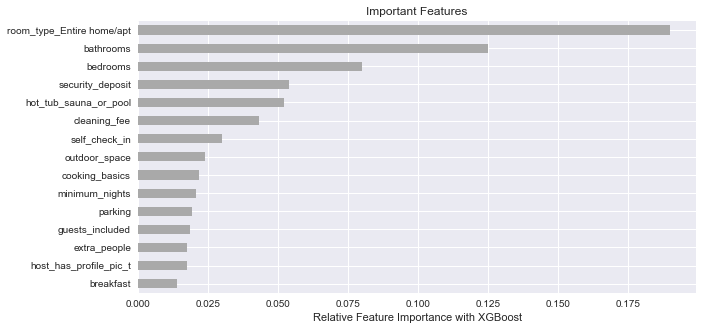

In [99]:
# plot the important features
feat_importances = pd.Series(booster.feature_importances_, index=features_recoded.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))
plt.xlabel('Relative Feature Importance with XGBoost')
plt.title('Important Features');

As we see, the **most important features are size, distance, and cleaning fee**, which account for approximately 45% of the daily price. Other top features are the number of people the apartment accommodates, other fees such as security deposit or the price for extra people, minimum night stay and bathrooms.

*Back to: <a href='#Table of contents'> Table of contents</a>*
### 6. Appendix 
<a id='6. Appendix'></a>

All resources used in this notebook are listed below.

Data
- http://insideairbnb.com/get-the-data.html

Imputing missing values with Linear Regression
- https://towardsdatascience.com/the-tale-of-missing-values-in-python-c96beb0e8a9d

XGBoost
- https://www.datacamp.com/community/tutorials/xgboost-in-python
- https://www.kaggle.com/marcelo06/cross-validation-with-xgboost-python

Geocoding
- https://pypi.org/project/geopy/

Centroid of Berlin (in German!)
- https://www.tagesspiegel.de/berlin/bezirke/friedrichshain-kreuzberg/reise-zum-mittelpunkt-berlins-am-ruhepol/9837502.html

Visualizations
- https://python-graph-gallery.com
- https://www.kaggle.com/kostyabahshetsyan/boston-airbnb-visualization

Inspiration for Analysis
- https://towardsdatascience.com/digging-into-airbnb-data-reviews-sentiments-superhosts-and-prices-prediction-part1-6c80ccb26c6a
- https://www.kaggle.com/ibjohnsson/predicting-listing-prices
- https://www.kaggle.com/mathvv/prediction-on-house-prices-xgboost-tutorial
- https://towardsdatascience.com/improving-airbnb-yield-prediction-with-text-mining-9472c0181731
- https://github.com/joaeechew/airbnb_nlp/blob/master/Capstone%20Project.ipynb